In [12]:
import os, sys, re, ast, json
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
import joblib
from typing import List, Dict, Tuple, Optional

# paths
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, PROJECT_ROOT)

from src.io_utils import load_df  # keep your project loader

X_TEST_PATH   = os.path.join(PROJECT_ROOT, "data/processed/X_test.csv")
Y_TEST_PATH   = os.path.join(PROJECT_ROOT, "data/processed/y_test.csv")
X_TRAIN_PATH  = os.path.join(PROJECT_ROOT, "data/processed/X_train.csv")

RF_MODEL_PATH  = os.path.join(PROJECT_ROOT, "models/rf_baseline.pkl")
XGB_MODEL_PATH = os.path.join(PROJECT_ROOT, "models/xgb_classifier.pkl")

FIG_DIR     = os.path.join(PROJECT_ROOT, "figures")
REPORTS_DIR = os.path.join(PROJECT_ROOT, "reports")
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(REPORTS_DIR, exist_ok=True)


In [13]:
# Use the project loader so it behaves the same as the rest of your pipeline
X_train = load_df(X_TRAIN_PATH)
X_test  = load_df(X_TEST_PATH)
y_test  = load_df(Y_TEST_PATH).iloc[:, 0]  # first column as Series

print("Shapes:", X_train.shape, X_test.shape, y_test.shape)
print("Dtypes (X_test):\n", X_test.dtypes.value_counts())


Shapes: (3539, 18) (885, 18) (885,)
Dtypes (X_test):
 float64    10
int64       8
Name: count, dtype: int64


In [14]:
def looks_like_list_string(s: str) -> bool:
    # quick heuristic: starts with [ and ends with ] and contains at least one comma or space-separated numbers
    return isinstance(s, str) and s.strip().startswith("[") and s.strip().endswith("]")

def try_parse_list(s: str):
    try:
        return ast.literal_eval(s)
    except Exception:
        return s  # keep original if parsing fails

def expand_list_column(df: pd.DataFrame, col: str) -> pd.DataFrame:
    """Expand a column containing list-like values into multiple numeric columns."""
    parsed = df[col].apply(lambda v: try_parse_list(v) if isinstance(v, str) else v)
    # find the first list to infer length
    first_list = next((v for v in parsed if isinstance(v, (list, tuple, np.ndarray))), None)
    if first_list is None:
        # nothing to expand, just return
        return df
    k = len(first_list)
    # ensure all list-like values have same length k; coerce where possible
    def coerce_to_len_k(v):
        if isinstance(v, (list, tuple, np.ndarray)):
            v = list(v)
            if len(v) == k:
                return v
        # fallback: fill with NaNs
        return [np.nan]*k

    arr = np.vstack(parsed.apply(coerce_to_len_k).values)
    new_cols = [f"{col}_{i}" for i in range(k)]
    df[new_cols] = arr.astype(np.float32)
    df = df.drop(columns=[col])
    return df

def coerce_object_columns(df: pd.DataFrame) -> pd.DataFrame:
    """For any object column, if it looks like a list-string in >=20% rows, expand it.
       Otherwise try to cast to numeric; if fail, keep as-is to drop later."""
    df = df.copy()
    obj_cols = df.select_dtypes(include="object").columns.tolist()
    for col in obj_cols:
        s = df[col].dropna().astype(str)
        share_listlike = (s.map(looks_like_list_string)).mean() if len(s) else 0.0
        if share_listlike >= 0.2:
            df = expand_list_column(df, col)
        else:
            # try numeric cast
            try:
                df[col] = pd.to_numeric(df[col], errors="raise")
            except Exception:
                # leave for now; we'll drop non-numeric later
                pass
    return df

def enforce_numeric_and_align(X: pd.DataFrame, reference_columns: Optional[List[str]] = None) -> pd.DataFrame:
    """Ensure all columns are numeric; drop non-numeric; align column order to reference if provided."""
    X = coerce_object_columns(X)
    # Drop any remaining non-numeric columns
    numeric_X = X.select_dtypes(include=[np.number]).copy()
    # float32 to be safe with SHAP & XGBoost
    for c in numeric_X.columns:
        if not np.issubdtype(numeric_X[c].dtype, np.number):
            numeric_X[c] = pd.to_numeric(numeric_X[c], errors="coerce")
    numeric_X = numeric_X.astype(np.float32)

    if reference_columns is not None:
        # add missing columns as zeros
        for col in reference_columns:
            if col not in numeric_X.columns:
                numeric_X[col] = 0.0
        # drop extras not seen in reference
        extra = [c for c in numeric_X.columns if c not in reference_columns]
        if extra:
            numeric_X = numeric_X.drop(columns=extra)
        # reorder
        numeric_X = numeric_X[reference_columns]
    return numeric_X


In [15]:
rf_model  = joblib.load(RF_MODEL_PATH)   # RandomForestClassifier
xgb_model = joblib.load(XGB_MODEL_PATH)  # XGBClassifier (sklearn API)

# Prefer model.feature_names_in_ if available for consistent ordering
reference_cols = None
for m in [xgb_model, rf_model]:
    if hasattr(m, "feature_names_in_"):
        reference_cols = list(m.feature_names_in_)
        break

X_train_sanitized = enforce_numeric_and_align(X_train, reference_cols)
X_test_sanitized  = enforce_numeric_and_align(X_test,  reference_cols)

print("After sanitize -> X_train:", X_train_sanitized.shape, X_train_sanitized.dtypes.unique())
print("After sanitize -> X_test:",  X_test_sanitized.shape,  X_test_sanitized.dtypes.unique())


After sanitize -> X_train: (3539, 18) [dtype('float32')]
After sanitize -> X_test: (885, 18) [dtype('float32')]


In [23]:
# --- Cell 5: robust SHAP setup with strict numeric checks and NumPy masker ---

# 1) Hard assertions to catch any residual string/list values early
def assert_strict_numeric(df: pd.DataFrame, name: str):
    bad_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
    if bad_cols:
        raise TypeError(f"{name} has non-numeric columns: {bad_cols}")
    # also ensure no list-like strings snuck in
    # (cheap scan over a few rows to avoid huge cost)
    head = df.head(50).astype(str)
    if head.apply(lambda col: col.str.match(r"^\s*\[.*\]\s*$", na=False).any()).any():
        raise TypeError(f"{name} still contains list-like strings like '[3.33E-1,...]'")

assert_strict_numeric(X_train_sanitized, "X_train_sanitized")
assert_strict_numeric(X_test_sanitized,  "X_test_sanitized")

# 2) Build a small numeric background and use NumPy for the masker
def background_sample(X: pd.DataFrame, n: int = 200) -> pd.DataFrame:
    return X if len(X) <= n else X.sample(n=n, random_state=42)

bg_df = background_sample(X_train_sanitized, n=200)
assert_strict_numeric(bg_df, "bg_df")

FEATURES = list(X_train_sanitized.columns)

# Use pure NumPy for the masker to avoid pandas dtype quirks
bg_np = bg_df.to_numpy(dtype=np.float32)
masker = shap.maskers.Independent(bg_np)

# 3) Wrap predict_proba in callables that accept NumPy and rebuild a DataFrame with the correct columns
def _to_df(data_np):
    # SHAP will pass an ndarray; rebuild a DF with the exact feature order
    return pd.DataFrame(data_np, columns=FEATURES)

def xgb_predict_proba1(data_np):
    X_df = _to_df(data_np)
    return xgb_model.predict_proba(X_df)[:, 1]

def rf_predict_proba1(data_np):
    X_df = _to_df(data_np)
    return rf_model.predict_proba(X_df)[:, 1]

# 4) Build explainers using the callable + NumPy masker (no TreeExplainer here)
xgb_explainer = shap.Explainer(xgb_predict_proba1, masker, feature_names=FEATURES)
rf_explainer  = shap.Explainer(rf_predict_proba1,  masker, feature_names=FEATURES)

# 5) Use a slice to keep runtime reasonable
N_SLICE = 300
X_slice_df = (X_test_sanitized.sample(N_SLICE, random_state=42)
              if len(X_test_sanitized) > N_SLICE else X_test_sanitized)
X_slice_np = X_slice_df.to_numpy(dtype=np.float32)

# 6) Compute SHAP values (pass check_additivity here if your SHAP supports it)
xgb_shap_values = xgb_explainer(X_slice_np)
rf_shap_values  = rf_explainer(X_slice_np)

print("OK. Shapes:",
      "X_slice", X_slice_df.shape,
      "| XGB shap", getattr(xgb_shap_values.values, 'shape', None),
      "| RF shap",  getattr(rf_shap_values.values, 'shape', None))


PermutationExplainer explainer: 301it [01:53,  2.40it/s]                         
PermutationExplainer explainer: 301it [28:56,  5.81s/it]                         

OK. Shapes: X_slice (300, 18) | XGB shap (300, 18) | RF shap (300, 18)


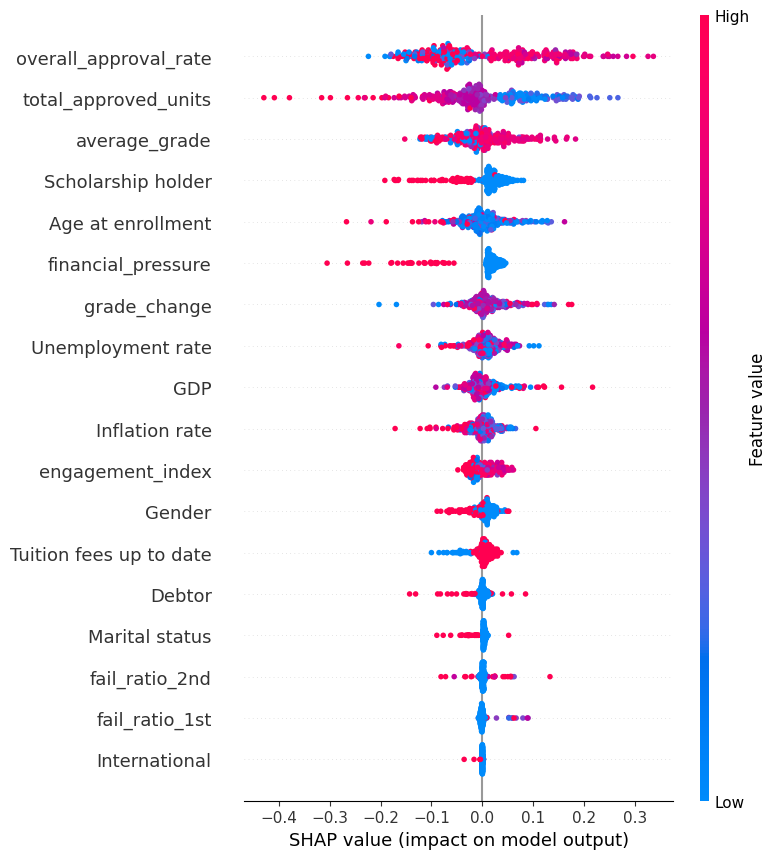

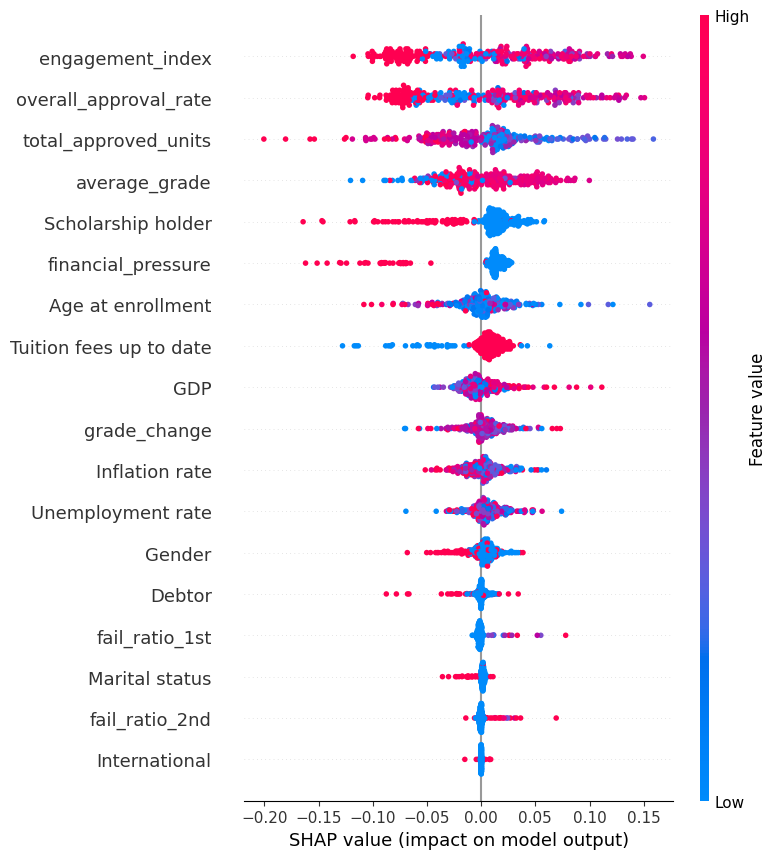

In [25]:
# --- Final plotting cell (compatible with NumPy-masker explainers) ---

def safe_summary_plot(expl, X_df, out_name):
    plt.figure()
    try:
        # Preferred: pass the Explanation object + features
        shap.summary_plot(expl, features=X_df, feature_names=list(X_df.columns), show=False)
    except Exception:
        # Fallback for older SHAP: pass the .values explicitly
        vals = getattr(expl, "values", expl)
        shap.summary_plot(vals, features=X_df, feature_names=list(X_df.columns), show=False)
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, out_name), dpi=200, bbox_inches="tight")
    plt.show()

safe_summary_plot(xgb_shap_values, X_slice_df, "shap_summary_xgb.png")
safe_summary_plot(rf_shap_values,  X_slice_df, "shap_summary_rf.png")
